## Get data

In [56]:
#imports
from astroquery.gaia import Gaia
import pandas as pd 
import seaborn as sns

In [11]:
#gaia query
job = Gaia.launch_job_async("SELECT ALL gaia_source.source_id,gaia_source.ra,gaia_source.dec,gaia_source.pmra,gaia_source.pmdec,gaia_source.phot_bp_mean_mag FROM gaiadr2.gaia_source WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),CIRCLE('ICRS',183.721,12.785,3))=1  AND  (gaiadr2.gaia_source.phot_bp_mean_mag<=17)")

Query finished.


In [12]:
#get resulting gaia datatable
r = job.get_results() #print(r['ra','dec'])
dt_gaia = r.to_pandas()

In [42]:
#read apt datatable
filename = "ca2183_apt.csv"
dt_apt_ = pd.read_csv(filename) 
dt_apt = dt_apt[['ApertureRA', 'ApertureDec','Magnitude', 'MagUncertainty']]

## Plots

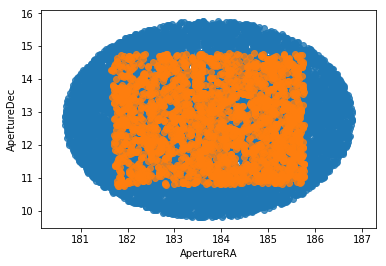

In [71]:
#ra and dec matching
sns.regplot('ra', 'dec', data=dt_gaia, fit_reg = False)
sns.regplot('ApertureRA', 'ApertureDec', data=dt_apt, fit_reg = False)